In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import emd
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter
from scipy import ndimage


In [2]:
output_dir = "./00007656_s010_t000_processed_data"
results_dir = "./results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [3]:
fs = 256                # Frequência de amostragem
channel = "EEG_F3-REF"  # Canal a ser analisado

# HHSA para um paciente e um canal

In [4]:
def holospectrum_single_channel(data, fs=256):
    """
    Aplica Holo-Hilbert Spectral Analysis (HHSA) ao sinal de EEG de um único canal.
    """
    # Garantir que o dado seja uma matriz 2D com dimensões corretas
    if data.ndim == 1:
        data = data.reshape(-1, 1)  # Reshape para (n_samples, 1)
    
    # Configuração da Decomposição
    config = emd.sift.get_config('mask_sift')
    config['max_imfs'] = 4
    config['mask_freqs'] = 'if'
    config['mask_amp_mode'] = 'ratio_imf'
    config['imf_opts/sd_thresh'] = 0.5
    config['mask_step_factor'] = 5

    # Decomposição usando Mask SIFT
    imf = emd.sift.mask_sift(data, **config)

    # Transformada de Hilbert
    IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'nht')

    # Segunda camada de decomposição
    masks = np.array([25 / 2**ii for ii in range(12)]) / fs
    imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

    # Transformada de Hilbert na segunda camada
    IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, fs, 'nht')

    # Definição dos histogramas para carrier e amplitude
    carrier_hist = (1, 100, 128, 'log')  # Ajuste se necessário
    am_hist = (1e-2, 100, 128, 'log')   # Ajuste se necessário

    # Computar HHT
    fcarrier, hht = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_time=False)
    shht = ndimage.gaussian_filter(hht, 2)

    # Ajuste de dimensões para alinhar IF e IF2
    if IF.shape[0] != IF2.shape[0]:
        IF = IF[:min(IF.shape[0], IF2.shape[0])]
        IF2 = IF2[:min(IF.shape[0], IF2.shape[0])]

    # Garantir que IF, IF2 e IA2 tenham as dimensões corretas
    IF = np.squeeze(IF)  # Remover a terceira dimensão extra
    IF2 = np.squeeze(IF2)  # Remover a terceira dimensão extra
    IA2 = np.squeeze(IA2)  # Ajustar IA2 para ter 2 dimensões

    # Verificar as dimensões antes de passar para o cálculo do holo
    print(f"Shape de IF: {IF.shape}")
    print(f"Shape de IF2: {IF2.shape}")
    print(f"Shape de IA2: {IA2.shape}")

    # Computar HHSA
    fcarrier, fam, holo = emd.spectra.holospectrum(IF, IF2, IA2, carrier_hist, am_hist)
    sholo = ndimage.gaussian_filter(holo, 1)

    np.nan_to_num(sholo, copy=False)

    # Computar o espectro de potência
    spec = np.mean(IA**2, axis=0)

    return fcarrier, fam, sholo, shht, spec

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

def process_single_channel(output_dir, channel, fs=256, result_dir='./results'):
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    # Carregar o sinal
    signal_path = os.path.join(output_dir, f"{channel}.npy")
    signal = np.load(signal_path)

    # Garantir que o sinal seja 1D
    if signal.ndim != 1:
        signal = signal.flatten()

    # Obter a análise do espectro Holo-Hilbert
    fcarrier, fam, sholo, shht, spec = holospectrum_single_channel(signal, fs)

    # Ajustar as dimensões de fcarrier e fam para coincidir com shht
    fcarrier = np.resize(fcarrier, shht.shape[0])  # Ajustar para o número de linhas de shht
    fam = np.resize(fam, shht.shape[1])  # Ajustar para o número de colunas de shht

    # Plotando e salvando os resultados separadamente
    # HHT
    fig, ax = plt.subplots(figsize=(10, 8))
    cp = ax.contourf(fcarrier, fcarrier, shht.T, cmap='jet', levels=40)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('Hilbert-Huang Transform')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Frequency (Hz)')
    plt.colorbar(cp, ax=ax)
    plt.tight_layout()
    plt.savefig(f'{result_dir}/hht_{channel}.png', dpi=100, bbox_inches='tight')
    plt.close()

    # HHSA
    fig, ax = plt.subplots(figsize=(10, 8))
    cp = ax.contourf(fcarrier, fam, sholo.T, cmap='jet', levels=40)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('Holo-Hilbert Spectrum')
    ax.set_xlabel('FM Frequency (Hz)')
    ax.set_ylabel('AM Frequency (Hz)')
    plt.colorbar(cp, ax=ax)
    plt.tight_layout()
    plt.savefig(f'{result_dir}/hhsa_{channel}.png', dpi=100, bbox_inches='tight')
    plt.close()

    # Marginal Spectrum
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(fcarrier, np.sum(shht, axis=1))
    ax.set_xscale('log')
    ax.set_title('Marginal Spectrum')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude')
    plt.tight_layout()
    plt.savefig(f'{result_dir}/marginal_spectrum_{channel}.png', dpi=100, bbox_inches='tight')
    plt.close()

    # Power Spectrum
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(fcarrier, spec)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Power Spectrum')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    plt.tight_layout()
    plt.savefig(f'{result_dir}/power_spectrum_{channel}.png', dpi=100, bbox_inches='tight')
    plt.close()

    print(f"Holo-Hilbert Spectral Analysis concluído para o canal {channel}!")

Shape de IF: (258048, 4)
Shape de IF2: (258048, 4, 4)
Shape de IA2: (258048, 4, 4)


TypeError: Length of y (128) must match number of rows in z (258048)

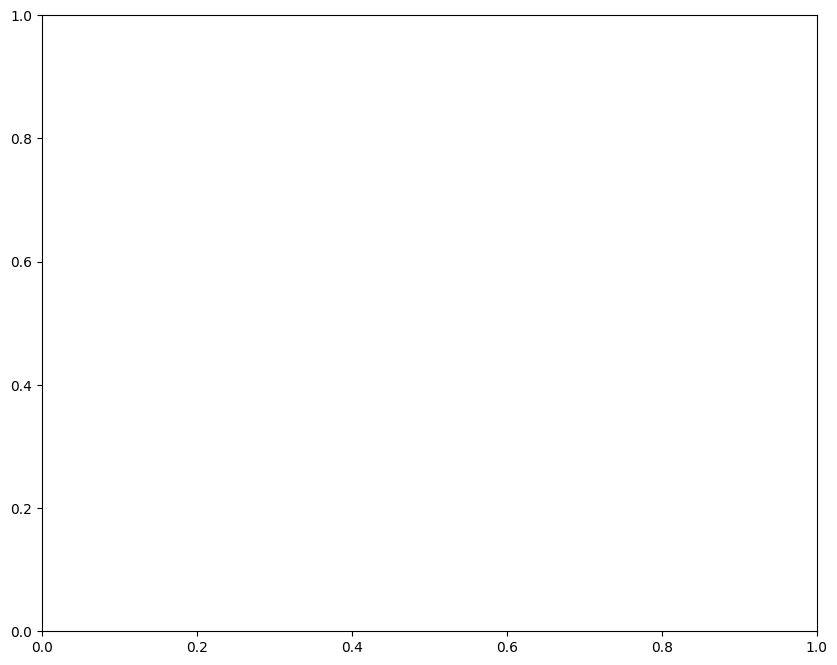

In [6]:
# Aplicação no dado
process_single_channel(output_dir, channel,fs)